# 라이브러리 로드

In [3]:

# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from lightgbm import LGBMRegressor as lgb
import lightgbm as lgb
# Classification

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

# FE코드

In [5]:
### Feature engineering of all
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('D', method='ffill')
    raw['count'].fillna(method='ffill',inplace=True)

    result = sm.tsa.seasonal_decompose(raw['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw.columns:
        if 'count_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    #Y_count_Day = raw[['count']].rolling(31).mean()
    #Y_count_Day.fillna(method='ffill', inplace=True)
    #Y_count_Day.fillna(method='bfill', inplace=True)
    #Y_count_Day.columns = ['count_Month']
    #Y_count_Week = raw[['count']].rolling(365).mean()
    #Y_count_Week.fillna(method='ffill', inplace=True)
    #Y_count_Week.fillna(method='bfill', inplace=True)
    #Y_count_Week.columns = ['count_Year']
    #if 'count_Month' not in raw.columns:
    #    raw = pd.concat([raw, Y_count_Day], axis=1)
    #if 'count_Year' not in raw.columns:
    #    raw = pd.concat([raw, Y_count_Week], axis=1)

    # STL분해 중 잔차 구하기
    result = sm.tsa.seasonal_decompose(raw['count'], model='additive',period=30,two_sided=False)
    Y_remainder = pd.DataFrame(result.resid)
    Y_remainder.fillna(method='ffill', inplace=True)
    Y_remainder.fillna(method='bfill', inplace=True)
    Y_remainder.columns = ['count_resid']
    raw = pd.concat([raw, Y_remainder], axis=1)
    
    #시간 변수 만들기
    raw['year'] = pd.DatetimeIndex(raw.index).year
    raw['month'] = pd.DatetimeIndex(raw.index).month
    raw['day'] = pd.DatetimeIndex(raw.index).day
    raw['day_of_year'] = pd.DatetimeIndex(raw.index).dayofyear
    raw['week_of_year'] = pd.DatetimeIndex(raw.index).weekofyear
    raw['season'] = raw.month%12 // 3 + 1
    raw['Quater'] = (raw.index.quarter)
    raw['Quater_ver2'] =(raw['Quater'] + (raw.year - raw.year.min()) * 4)
    if 'Quater' in raw.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quater'], 
                                                 prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw['Quater']
    month_in_year = 12
    raw['month_sin'] = np.sin(2*np.pi*raw.month/month_in_year)
    raw['month_cos'] = np.cos(2*np.pi*raw.month/month_in_year)
    
    days_in_month = 30
    raw['day_sin'] = np.sin(2*np.pi*raw.day/days_in_month)
    raw['day_cos'] = np.cos(2*np.pi*raw.day/days_in_month)
    
    days_in_year = 365
    raw['day_of_year_sin'] = np.sin(2*np.pi*raw.day_of_year/days_in_year)
    raw['day_of_year_cos'] = np.cos(2*np.pi*raw.day_of_year/days_in_year)
    
    weeks_in_year = 52.1429
    raw['week_of_year_sin'] = np.sin(2*np.pi*raw.week_of_year/weeks_in_year)
    raw['week_of_year_cos'] = np.cos(2*np.pi*raw.week_of_year/weeks_in_year)
    
    seasons_in_year = 4
    raw['season_sin'] = np.sin(2*np.pi*raw.season/seasons_in_year)
    raw['season_cos'] = np.cos(2*np.pi*raw.season/seasons_in_year)
    raw.drop(['day', 'day_of_year', 'week_of_year', 'season'],axis=1,inplace=True)
    
    #가격 관련 변수 추가
    raw['rolling_mean_t7'] = raw['count'].transform(lambda x: x.ewm(span=7,min_periods=1,adjust=True,ignore_na=False).mean())
    raw['rolling_mean_t30'] = raw['count'].transform(lambda x: x.ewm(span=30,min_periods=1,adjust=True,ignore_na=False).mean())
    raw['rolling_mean_t90'] = raw['count'].transform(lambda x: x.ewm(span=90,min_periods=1,adjust=True,ignore_na=False).mean())
    raw['rolling_mean_t180'] = raw['count'].transform(lambda x: x.ewm(span=180,min_periods=1,adjust=True,ignore_na=False).mean())
    raw['rolling_mean_t240'] = raw['count'].transform(lambda x: x.ewm(span=240,min_periods=1,adjust=True,ignore_na=False).mean())
    raw['rolling_mean_t300'] = raw['count'].transform(lambda x: x.ewm(span=300,min_periods=1,adjust=True,ignore_na=False).mean())
    raw['rolling_mean_t365'] = raw['count'].transform(lambda x: x.ewm(span=365,min_periods=1,adjust=True,ignore_na=False).mean())
    
    for a in range(1,366):
        raw[f'count_lag{a}'] = raw['count'].shift(a)
        raw[f'count_lag{a}'].fillna(0,inplace=True)
    
    raw['P_diff']=raw['count'].diff(1)
    raw['P_diff'].fillna(0,inplace=True)
    #raw['Year_a_go'] = raw['count'].shift(365)
    #raw['Y_diff'] = raw['count']-raw['Year_a_go']
    raw['P_sum'] = raw['count']+raw['P_diff']

    raw['month'] =(raw['month'] + (raw.year - raw.year.min()) * 12)
    mapd = raw.groupby('month')['count'].mean()
    mapd = pd.DataFrame(mapd,index=mapd.index)  
    mapd.reset_index(drop=False,inplace=True)
    mapd.columns=['month','Mapd']
    raw = pd.merge(raw,mapd,how='left',left_on='month',right_on='month')
    raw['R_p'] = raw['count']-raw['Mapd']
    
    raw.drop(['Mapd'],axis=1,inplace=True)
    
    raw['1dayafter']= raw['count'].shift(-1)
    raw['1dayafter'].fillna(-1,inplace=True)
    
    return raw

In [6]:
### Data split of time series
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test

In [7]:
### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te

# 데이터 로드

In [66]:
raw = pd.read_excel('7월4일FE새로.xlsx')
raw.drop(['Unnamed: 0'],axis=1,inplace=True)

raw = raw.iloc[:,:2]

raw.columns = ['datetime','count']

raw.set_index('datetime',inplace=True)

# Train,Test split

raw=raw[raw.index <='2021-12-31']
test=raw[raw.index >= '2021-01-01']
train=raw[raw.index < '2021-01-01']

# tf로드

In [6]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.models import load_model
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime, timedelta, timezone
import keras
from datetime import datetime, timedelta, timezone

# LGBM 모델 구축

In [29]:
model_dict={}
for day_num in tqdm(range(1,366)):
    if day_num==1:
        for i in range(1,366):
            train[f'count_{i}lag'] = train['count'].shift(i)
        
        train.fillna(method='bfill',inplace=True)
        
        y = train['count']
        x = train.drop(['count'],axis=1)
        x_slice = x.iloc[365:]
        y_slice = y.iloc[365:]
        
        params = {'num_leaves': 555,
          'min_child_weight': 0.034,
          'feature_fraction': 0.379,
          'bagging_fraction': 0.418,
          'min_data_in_leaf': 106,
          'objective': 'regression',
          'max_depth': -1,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'rmse',
          "verbosity": -1,
          'reg_alpha': 0.3899,
          'reg_lambda': 0.648,
          'random_state': 222,
         }
               
        dtrain = lgb.Dataset(x_slice, label=y_slice)
        model_dict[f'lgb_{day_num}'] = lgb.train(params, dtrain, 2500,verbose_eval=100)
        # save model
        joblib.dump(model_dict[f'lgb_{day_num}'],f'lgb{day_num}.pkl')
        
        # prediction
        Y_train_pred = model_dict[f'lgb_{day_num}'].predict(x)
    

    else:
        train = train.iloc[:,:day_num-1]
        
        for you in range(1,day_num-1):
            train[f'Y_{you}pred'] = train[f'Y_{you}pred'].shift(1)
        
        train[f'Y_{day_num-1}pred'] = 0
        train[f'Y_{day_num-1}pred'] = Y_train_pred
        train[f'Y_{day_num-1}pred'] = train[f'Y_{day_num-1}pred'].shift(1)
        
        new = train.columns[-1:].to_list()
        count = train.columns[:1].to_list()
        old = train.columns[1:day_num-1].to_list()
        new_col = count+new+old
        train = train[new_col]
        
        for i in range(day_num,366):
            train[f'count_{i}lag'] = train['count'].shift(i)
        train.fillna(method='bfill',inplace=True)
        
        # x,y split
        y = train['count']
        x = train.drop(['count'],axis=1)
        x_slice = x.iloc[365:]
        y_slice = y.iloc[365:]
                
        params = {'num_leaves': 555,
          'min_child_weight': 0.034,
          'feature_fraction': 0.379,
          'bagging_fraction': 0.418,
          'min_data_in_leaf': 106,
          'objective': 'regression',
          'max_depth': -1,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'rmse',
          "verbosity": -1,
          'reg_alpha': 0.3899,
          'reg_lambda': 0.648,
          'random_state': 222,
         }
               
        dtrain = lgb.Dataset(x_slice, label=y_slice)
        model_dict[f'lgb_{day_num}'] = lgb.train(params, dtrain, 2500,verbose_eval=100)
        # save model
        joblib.dump(model_dict[f'lgb_{day_num}'],f'lgb{day_num}.pkl')
        
        # prediction
        Y_train_pred = model_dict[f'lgb_{day_num}'].predict(x)

100%|████████████████████████████████████████████████████████████████████████████████| 365/365 [20:00<00:00,  3.29s/it]


In [62]:
x_slice

,Y_1pred,count_2lag,count_3lag,count_4lag,count_5lag,count_6lag,count_7lag,count_8lag,count_9lag,count_10lag,count_11lag,count_12lag,count_13lag,count_14lag,count_15lag,count_16lag,count_17lag,count_18lag,count_19lag,count_20lag,...,count_346lag,count_347lag,count_348lag,count_349lag,count_350lag,count_351lag,count_352lag,count_353lag,count_354lag,count_355lag,count_356lag,count_357lag,count_358lag,count_359lag,count_360lag,count_361lag,count_362lag,count_363lag,count_364lag,count_365lag
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-03-27,495.73,435.80,490.36,483.99,530.82,530.82,558.86,517.67,484.95,503.33,539.29,476.17,476.17,482.45,534.41,535.59,473.69,433.93,501.22,501.22,...,553.74,590.70,572.30,572.30,534.74,558.54,562.76,563.15,510.25,546.52,546.52,481.98,466.72,461.09,400.00,540.96,459.66,459.66,501.85,0.00
2015-03-28,496.05,453.78,435.80,490.36,483.99,530.82,530.82,558.86,517.67,484.95,503.33,539.29,476.17,476.17,482.45,534.41,535.59,473.69,433.93,501.22,...,564.93,553.74,590.70,572.30,572.30,534.74,558.54,562.76,563.15,510.25,546.52,546.52,481.98,466.72,461.09,400.00,540.96,459.66,459.66,501.85
2015-03-29,493.58,424.14,453.78,435.80,490.36,483.99,530.82,530.82,558.86,517.67,484.95,503.33,539.29,476.17,476.17,482.45,534.41,535.59,473.69,433.93,...,609.62,564.93,553.74,590.70,572.30,572.30,534.74,558.54,562.76,563.15,510.25,546.52,546.52,481.98,466.72,461.09,400.00,540.96,459.66,459.66
2015-03-30,482.32,481.73,424.14,453.78,435.80,490.36,483.99,530.82,530.82,558.86,517.67,484.95,503.33,539.29,476.17,476.17,482.45,534.41,535.59,473.69,...,632.81,609.62,564.93,553.74,590.70,572.30,572.30,534.74,558.54,562.76,563.15,510.25,546.52,546.52,481.98,466.72,461.09,400.00,540.96,459.66
2015-03-31,475.27,481.73,481.73,424.14,453.78,435.80,490.36,483.99,530.82,530.82,558.86,517.67,484.95,503.33,539.29,476.17,476.17,482.45,534.41,535.59,...,660.18,632.81,609.62,564.93,553.74,590.70,572.30,572.30,534.74,558.54,562.76,563.15,510.25,546.52,546.52,481.98,466.72,461.09,400.00,540.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,"1,172.36","1,124.65","1,157.50","1,189.24","1,135.12","1,148.75","1,140.88","1,140.88","1,539.71","1,164.55","1,092.83","1,155.22","1,153.17","1,130.62","1,130.62","1,117.23","1,107.82","1,161.04","1,150.54","1,099.57",...,802.77,848.84,840.91,855.25,871.13,871.13,843.25,852.71,863.16,838.42,799.50,753.54,753.54,730.42,683.83,702.32,702.32,721.55,696.36,696.36
2020-12-28,"1,190.14","1,198.20","1,124.65","1,157.50","1,189.24","1,135.12","1,148.75","1,140.88","1,140.88","1,539.71","1,164.55","1,092.83","1,155.22","1,153.17","1,130.62","1,130.62","1,117.23","1,107.82","1,161.04","1,150.54",...,823.67,802.77,848.84,840.91,855.25,871.13,871.13,843.25,852.71,863.16,838.42,799.50,753.54,753.54,730.42,683.83,702.32,702.32,721.55,696.36
2020-12-29,"1,208.34","1,198.20","1,198.20","1,124.65","1,157.50","1,189.24","1,135.12","1,148.75","1,140.88","1,140.88","1,539.71","1,164.55","1,092.83","1,155.22","1,153.17","1,130.62","1,130.62","1,117.23","1,107.82","1,161.04",...,802.92,823.67,802.77,848.84,840.91,855.25,871.13,871.13,843.25,852.71,863.16,838.42,799.50,753.54,753.54,730.42,683.83,702.32,702.32,721.55


# inference

In [77]:
pred = []
for j in tqdm([30, 90, 180, 270, 365]):
    for ic in range(1,366):
        x_test = pd.DataFrame(raw.iloc[-365-j+ic]).T
        x_test.drop(['count'],axis=1,inplace=True)
        for day in range(1,j):
            
            load_model=joblib.load(f'lgb{day}.pkl')
            y_test_pred=load_model.predict(x_test)
            
            x_test.iloc[:,-1:] = y_test_pred
            
            old = x_test.columns[:-1].to_list()
            replace = x_test.columns[-1:].to_list()
            new = replace+old
            x_test = x_test[new]

        load_model=joblib.load(f'lgb{j}.pkl')
        y_test_pred=load_model.predict(x_test)
        pred.append(y_test_pred)

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [2:31:23<00:00, 1816.71s/it]


In [85]:
pred30=[]
pred90=[]
pred180=[]
pred270=[]
pred365=[]
for i in range(0,365):
    pred30.append(pred[i])
for i in range(365,730):
    pred90.append(pred[i])
for i in range(730,1095):
    pred180.append(pred[i])
for i in range(1095,1460):
    pred270.append(pred[i])
for i in range(1460,1825):
    pred365.append(pred[i])

In [86]:
len(pred30)

365

47.11218412222334
330.18565656172456


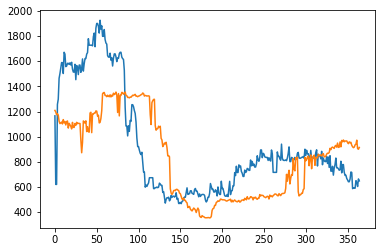

In [87]:
plot = pd.DataFrame([test['count'].values,pred30]).T
plot.columns=['actual','pred']
plt.plot(plot)

MAPE = (abs(test['count'].values - pred30)/test['count'].values*100).mean()
print(MAPE)

RMSE = np.sqrt(mean_squared_error(test['count'].values.flatten(), pred30))
print(RMSE)

49.890250261824285
404.40500184283275


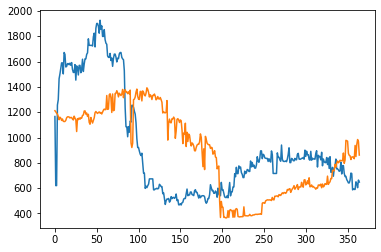

In [89]:
plot = pd.DataFrame([test['count'].values,pred90]).T
plot.columns=['actual','pred']
plt.plot(plot)

MAPE = (abs(test['count'].values - pred90)/test['count'].values*100).mean()
print(MAPE)

RMSE = np.sqrt(mean_squared_error(test['count'].values.flatten(), pred90))
print(RMSE)

51.83081627517918
426.84738866504523


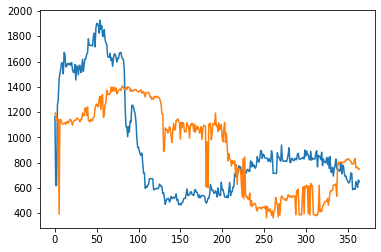

In [90]:
plot = pd.DataFrame([test['count'].values,pred180]).T
plot.columns=['actual','pred']
plt.plot(plot)

MAPE = (abs(test['count'].values - pred180)/test['count'].values*100).mean()
print(MAPE)

RMSE = np.sqrt(mean_squared_error(test['count'].values.flatten(), pred180))
print(RMSE)

50.99510967022706
434.83856780061416


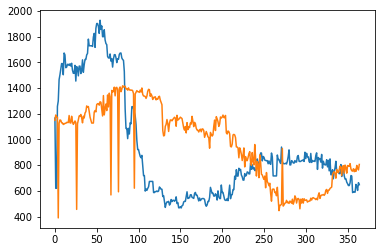

In [91]:
plot = pd.DataFrame([test['count'].values,pred270]).T
plot.columns=['actual','pred']
plt.plot(plot)

MAPE = (abs(test['count'].values - pred270)/test['count'].values*100).mean()
print(MAPE)

RMSE = np.sqrt(mean_squared_error(test['count'].values.flatten(), pred270))
print(RMSE)

47.968300891668896
431.2640994062312


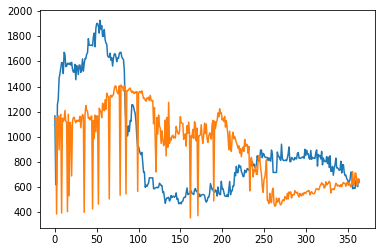

In [92]:
plot = pd.DataFrame([test['count'].values,pred365]).T
plot.columns=['actual','pred']
plt.plot(plot)

MAPE = (abs(test['count'].values - pred365)/test['count'].values*100).mean()
print(MAPE)

RMSE = np.sqrt(mean_squared_error(test['count'].values.flatten(), pred365))
print(RMSE)